<a href="https://colab.research.google.com/github/Vincenzo-Miracula/MasterSDS/blob/main/bluesky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

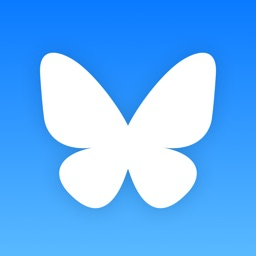

# Spiegazione del Codice Python per l'Estrazione di Post da Bluesky

### Introduzione
Il codice fornisce un esempio di come interagire con l'API di Bluesky (un social network decentralizzato) per estrarre i post da un feed utilizzando la libreria Python `atproto`. Il processo comprende l'autenticazione, la ricerca di post, e l'estrazione di informazioni sui post (come l'autore, il testo, e la data). I dati vengono poi organizzati in un DataFrame di Pandas per un'analisi successiva.

### Installazione e Importazione delle Librerie
Il codice inizia con l'installazione e l'importazione delle librerie necessarie:

- `atproto`: Libreria utilizzata per interagire con l'API di Bluesky.
- `requests`: Per inviare richieste HTTP.
- `json`: Per lavorare con risposte in formato JSON.
- `tqdm`: Per visualizzare una barra di avanzamento durante l'esecuzione dei loop.
- `time`: Per gestire pause tra le richieste.
- `pandas`: Per la manipolazione dei dati.
- `configparser`: Per leggere il file di configurazione.
- `datetime`: Per lavorare con date e orari.

### Lettura delle Credenziali
Il codice utilizza il modulo `configparser` per leggere le credenziali di accesso da un file `config.ini`.

### Autenticazione e Login
Le credenziali vengono utilizzate per effettuare il login su Bluesky tramite il metodo `login` della classe `Client`. Tuttavia, il `token` di autenticazione è vuoto nel codice, il che significa che deve essere riempito per funzionare correttamente.

### Preparazione della Richiesta API
L'endpoint dell'API di Bluesky per cercare i post è specificato nell'URL. Inoltre, vengono impostati i parametri della ricerca, come la query, il limite dei post da estrarre, l'ordinamento, e il tag per la ricerca.

### Funzione per Estrazione dei Post
La funzione `estrai_post` invia richieste API per ottenere i post da Bluesky. Utilizza la paginazione tramite un cursore per recuperare più post, se necessario. Inoltre, viene utilizzata la libreria `tqdm` per visualizzare una barra di avanzamento durante l'estrazione dei dati.

### Estrazione delle Informazioni dai Post
Una volta estratti i post, la funzione `estrai_displaynames_e_testi` raccoglie informazioni specifiche da ogni post, come l'handle dell'autore, il nome visualizzato, il testo del post, e la data di creazione.

### Creazione del DataFrame con Pandas
Infine, i dati estratti vengono convertiti in un DataFrame di Pandas per facilitare la visualizzazione e l'analisi. Ogni post è rappresentato da una riga nel DataFrame con le colonne `Author`, `Username`, `Text`, e `Date`.


In [ ]:
!pip install atproto

In [46]:
from atproto import Client
import requests
import json
from tqdm import tqdm
import time
import pandas as pd
import configparser
from datetime import datetime

In [4]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [ ]:
client = Client()
# By default, it uses the server of bsky.app. To change this behavior, pass the base api URL to constructor
client_id = config['bluesky']['client_id']
password_app = config['bluesky']['password_app']

client.login(client_id, password_app)

In [6]:
token = ''

In [ ]:
# URL dell'API
url = "https://milkcap.us-west.host.bsky.network/xrpc/app.bsky.feed.searchPosts"
headers = {"Authorization": f"Bearer {token}"}

# Parametri della richiesta
params = {
    "q": "",  # Query di ricerca
    "limit": 100,    # Limite massimo per ogni richiesta
    "sort": "latest", # Ordinamento dei risultati - top o latest
    "tag": '#',  # Filtro per il tag
}

def estrai_post(url, params, max_posts=400):
    all_posts = []
    cursor = None

    with tqdm(total=max_posts, desc="Estrazione post") as pbar:
        while len(all_posts) < max_posts:
            if cursor:
                params["cursor"] = cursor  # Usa il cursore per la paginazione
            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                data = response.json()
                all_posts.extend(data["posts"])
                pbar.update(len(data["posts"]))  # Aggiorna la barra di avanzamento

                cursor = data.get("cursor", None)
                if cursor is None:
                    break
            else:
                print(f"Errore nella richiesta: {response.status_code}")
                break

            time.sleep(1)  # Pausa prima della prossima richiesta

    return all_posts

data = estrai_post(url, params)
print(f"Numero di post estratti: {len(data)}")

In [ ]:
data[0]

In [ ]:
for post in data:
  print(post['record']['createdAt'])

In [38]:
def estrai_displaynames_e_testi(data):
    risultati = []
    for post in data:

      handle = post['author']['handle']
      displayname = post['author'].get('displayName', 'empty')
      text = post['record']['text']
      date = post['record']['createdAt']
      risultati.append((handle, displayname, text, date))
    return risultati

In [ ]:
for item in data:
    print(item.keys())[0]

In [42]:
content = estrai_displaynames_e_testi(data)

In [ ]:
len(pd.DataFrame(content))

400

In [58]:
df = pd.DataFrame(content, columns=['Author', 'Username', 'Text', 'Date'])

In [ ]:
df['Date'] = df['Date'].str.split('T').str[0]
df['Date']

In [62]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.info()